In [1]:
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

In [2]:
## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

In [3]:
class State(TypedDict):
    messages:Annotated[list, add_messages]

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
groq_api_key = os.getenv("GROQ_API_KEY")

In [6]:
from langchain_groq import ChatGroq

llm = ChatGroq(groq_api_key = groq_api_key, model="llama-3.1-8b-instant")

In [7]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def superbot(state: State):
    # state["messages"] is already a list[BaseMessage]; don't wrap it again
    ai_msg = llm.invoke(state["messages"])   # returns an AIMessage
    return {"messages": [ai_msg]}   

graph = StateGraph(State)

## Node
graph.add_node("SuperBot", superbot)

## Edges

graph.add_edge(START, "SuperBot")
graph.add_edge("SuperBot", END)

graph_builder = graph.compile(checkpointer=memory)

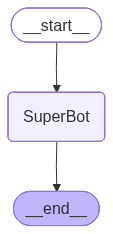

In [8]:
from IPython.display import Image, display

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [11]:
from langchain_core.messages import HumanMessage

config = {"configurable":{"thread_id":"1"}}

# ✅ Invoke with a list of messages (either BaseMessage or dict form)
out = graph_builder.invoke({
    "messages": [HumanMessage(content="What is Agentic AI?")],
    },
    config=config
)
print(out["messages"][-1].content)

Agentic AI refers to a type of artificial intelligence (AI) that possesses a sense of agency, which means it has the ability to act and make decisions independently, often with the goal of achieving a specific objective or outcome. In other words, agentic AI is designed to behave in a way that is goal-oriented, proactive, and autonomous.

Agentic AI systems often exhibit characteristics such as:

1. **Goal-directed behavior**: Agentic AI systems are designed to achieve specific goals or objectives, and they will take actions to accomplish these goals.
2. **Autonomy**: Agentic AI systems can operate independently, making decisions and taking actions without human intervention.
3. **Self-awareness**: Agentic AI systems may have some level of self-awareness, which allows them to understand their own capabilities, limitations, and motivations.
4. **Initiative**: Agentic AI systems can take the initiative to act, rather than simply responding to external stimuli.

Agentic AI has many potent

### Streaming 
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.


## Streaming the response with Stream method

In [12]:
config = {"configurable":{"thread_id":"2"}}

for chunk in graph_builder.stream({"messages": [HumanMessage(content="What is Agentic AI?")]},
                                  config=config,
                                  stream_mode = "updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Agentic AI refers to a type of artificial intelligence (AI) that is designed to exhibit autonomous, self-aware, and goal-oriented behavior. The term "agentic" comes from the concept of agency, which is often associated with human ability to act on one\'s own initiative and make decisions.\n\nIn the context of AI, agentic AI systems are capable of:\n\n1. **Autonomy**: They can operate independently, making decisions without direct human intervention.\n2. **Self-awareness**: They have a sense of their own existence, goals, and values.\n3. **Goal-oriented behavior**: They can set and pursue their own objectives, adapting to changing situations to achieve them.\n4. **Intentionality**: They can exhibit purposeful behavior, such as planning, reasoning, and problem-solving.\n\nAgentic AI systems are often designed to mimic human-like behavior, such as decision-making, problem-solving, and social interaction. They can learn from experience, adapt t

In [13]:
for chunk in graph_builder.stream({"messages": [HumanMessage(content="What is Agentic AI?")]},
                                  config=config,
                                  stream_mode = "values"):
    print(chunk) 

{'messages': [HumanMessage(content='What is Agentic AI?', additional_kwargs={}, response_metadata={}, id='d78d6be5-602e-442f-9308-8d5eb950e12b'), AIMessage(content='Agentic AI refers to a type of artificial intelligence (AI) that is designed to exhibit autonomous, self-aware, and goal-oriented behavior. The term "agentic" comes from the concept of agency, which is often associated with human ability to act on one\'s own initiative and make decisions.\n\nIn the context of AI, agentic AI systems are capable of:\n\n1. **Autonomy**: They can operate independently, making decisions without direct human intervention.\n2. **Self-awareness**: They have a sense of their own existence, goals, and values.\n3. **Goal-oriented behavior**: They can set and pursue their own objectives, adapting to changing situations to achieve them.\n4. **Intentionality**: They can exhibit purposeful behavior, such as planning, reasoning, and problem-solving.\n\nAgentic AI systems are often designed to mimic human-l

#### Streaming The Responses With astream Method

**Streaming tokens**
We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the **tokens** as they are generated.

We can do this using the .astream_events method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

- event: This is the type of event that is being emitted.
- name: This is the name of event.
- data: This is the data associated with the event.
- metadata: Containslanggraph_node, the node emitting the event.

In [14]:
config = {"configurable": {"thread_id": "3"}}

async for event in graph_builder.astream_events({"messages":["What is Agentic AGI?"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['What is Agentic AGI?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '078a2d6e-c6b1-4d54-b0f3-6a25562812dd', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='What is Agentic AGI?', additional_kwargs={}, response_metadata={}, id='035e0144-4e07-47b7-a5aa-8373e488dcbd')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '9fe2fa9c-22e2-430b-b2e5-b437d3e17be6', 'metadata': {'thread_id': '3', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:67b8c5c2-f812-e44b-fff5-6d4d5b60360b'}, 'parent_ids': ['078a2d6e-c6b1-4d54-b0f3-6a25562812dd']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='What is Agentic AGI?', additional_kwargs={}, response_metadata={}, id='035e0144-4e07-47b7